In [37]:
import tensorflow as tf
import TaylorSpatial_ModelTremor as TS
import pandas as pd
from scipy.spatial.distance import cdist
import numpy as np
from scipy.signal import butter, filtfilt
import tensorflow as tf
from tqdm import tqdm

In [61]:
def normalize_features(data):
    shape = data.shape
    data_reshaped = data.reshape(-1, shape[-1])  # flatten all but features
    means = data_reshaped.mean(axis=0)
    stds = data_reshaped.std(axis=0)
    stds[stds == 0] = 1.0 #avoid dividion by zero
    normalised = (data - means) / stds
    return normalised, means, stds

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def compute_derivatives(signal, dt):
    velocity = np.gradient(signal, dt)
    acceleration = np.gradient(velocity, dt)
    return velocity, acceleration

def extract_features(raw_data, sampling_rate = 100):
    """Returns "features" with a shape -> (num_tremors, num_stations, num_samples, 16) """
    
    raw_data, _, _ = normalize_features(raw_data) 
    
    num_stations, num_samples = raw_data.shape
    dt = 1.0 / sampling_rate
    
    features = np.zeros((num_stations, num_samples, 16))

    #Fibe bands (1hz width from 8 to 13hz)
    bands = [(8+i, 9+i) for i in range(5)]  

    for s in range(num_stations):
        #Raw signal as first feature
        features[s, :, 0] = raw_data[s, :]

        #Process each band
        for i, (low, high) in enumerate(bands):
            filtered = bandpass_filter(raw_data[s, :], low, high, sampling_rate)
            features[s, :, 1 + i] = filtered
                
            # Compute derivatives of filtered signal
            vel, acc = compute_derivatives(filtered, dt)
            features[s, :, 6 + 2*i] = vel
            features[s, :, 7 + 2*i] = acc

    return features

def split_data(features, train_n=100, val_n=10, test_n=34, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(features.shape[0])
    train_idx = indices[:train_n]
    val_idx = indices[train_n:train_n+val_n]
    test_idx = indices[train_n+val_n:train_n+val_n+test_n]
    train_set = features[train_idx]
    val_set = features[val_idx]
    test_set = features[test_idx]
    return train_set, val_set, test_set, train_idx, val_idx, test_idx

def window_one_tremor(x_tremor, y_tremor, window_size, step_size):

    n_nodes, total_time, n_feat = x_tremor.shape
    x_windows, y_windows = [], []

    for start in range(0, total_time - window_size + 1, step_size):
        end = start + window_size
        x_window = x_tremor[:, start:end, :]     # (12, window_size, 16)
        y_window = y_tremor[start:end]           # (window_size,)

        # Transpose x_window to (window_size, nodes, features)
        x_windows.append(np.transpose(x_window, (1, 0, 2)))
        y_windows.append(y_window)

    return np.array(x_windows), np.array(y_windows)

def Adjacency_Wrapper(locs_data, X_win):

    dist_matrix = cdist(coords, coords, metric='euclidean') 
    adj_matrix = 1 / (dist_matrix + 1e-5)
    threshold = np.percentile(adj_matrix, 75)
    adj_matrix[adj_matrix < threshold] = 0
    row_sums = adj_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    adj_matrix = adj_matrix / row_sums

    N = X_win.shape[0]  # number of windows
    A_batch = tf.repeat(tf.expand_dims(adj_matrix, 0), repeats=N, axis=0)

    return A_batch

In [5]:
Windowed_data = np.load("Windowed_data.npy")

In [32]:
df = pd.read_csv("stations_metadata.csv")
coords = df[["latitude", "longitude"]].to_numpy()

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from spektral.layers import GCNConv

class TimeDistributedGCN(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.gcn = GCNConv(channels, activation="relu")

    def call(self, x, a):
        b, t, n, f = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x_reshaped = tf.reshape(x, (-1, n, f))  
        a_tiled = tf.repeat(a, repeats=t, axis=0) 
        out = self.gcn([x_reshaped, a_tiled])
        return tf.reshape(out, (b, t, n, self.channels))

class TemporalTaylorBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_layers=2, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_layers = num_layers
        self.input_proj = tf.keras.layers.Dense(d_model)  # feature projection

        #Tylor-style 
        self.layers_ = [
            tf.keras.Sequential([
                tf.keras.layers.LayerNormalization(),
                tf.keras.layers.Dense(d_model, activation='relu'),
                tf.keras.layers.Dense(d_model)
            ]) for _ in range(num_layers)
        ]

    def call(self, x):
        b = tf.shape(x)[0]
        t = tf.shape(x)[1]
        n = tf.shape(x)[2]

        x = self.input_proj(x)  # -> (batch, time, nodes, d_model)
        x_reshaped = tf.reshape(x, (b * n, t, self.d_model))

       
        for layer in self.layers_:
            x_reshaped = x_reshaped + layer(x_reshaped)

        # shape Back to (bach, time, nodes, d_model)
        x_out = tf.reshape(x_reshaped, (b, t, n, self.d_model))
        return x_out

def build_stgnn_model(window_size,target_station, n_nodes, num_features, gcn_channels=32, temporal_dim=64, forecast_horizon=1):
    x_input = tf.keras.Input(shape=(window_size, n_nodes, num_features), name="node_features")
    a_input = tf.keras.Input(shape=(n_nodes, n_nodes), name="adj_matrix", dtype=tf.float32)

    gcn_out = TimeDistributedGCN(gcn_channels)(x_input, a_input)  # (batch, time, nodes, gcn_channels)

    temp_out = TemporalTaylorBlock(d_model=temporal_dim)(gcn_out)

    target_out = temp_out[:, :, target_station, :] 

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(target_out) 
    output = tf.keras.layers.Reshape((window_size,))(x) 

    return tf.keras.Model(inputs=[x_input, a_input], outputs=output)

In [94]:
window_size  = 200
step_size = 50
numfeatures = 16
n_nodes = 12
target_idx = 5
 
model = build_stgnn_model(window_size, target_idx, n_nodes, numfeatures)
model.compile(optimizer='adam', loss='mse')

for i in tqdm(range(100)):
        
    rawdata = Windowed_data[i]
    data = extract_features(rawdata)
    x_tremor = data # shape (12, 60001, 16)
    x_tremor[:, target_idx] = 0.0
    y_tremor = data[target_idx][:,0] #shape (60001,)

    X_train_win, y_train_win = window_one_tremor(x_tremor, y_tremor, window_size, step_size)
    A = Adjacency_Wrapper(coords, X_train_win)

    model.fit([X_train_win, A], y_train_win, epochs=20, batch_size=32)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/20
38/38 [==============================] - 15s 330ms/step - loss: 0.2439
Epoch 2/20
38/38 [==============================] - 12s 329ms/step - loss: 0.0265
Epoch 3/20
38/38 [==============================] - 12s 328ms/step - loss: 0.0120
Epoch 4/20
38/38 [==============================] - 13s 331ms/step - loss: 0.0074
Epoch 5/20
38/38 [==============================] - 13s 345ms/step - loss: 0.0055
Epoch 6/20
38/38 [==============================] - 13s 337ms/step - loss: 0.0044
Epoch 7/20
38/38 [==============================] - 13s 340ms/step - loss: 0.0036
Epoch 8/20
38/38 [==============================] - 13s 337ms/step - loss: 0.0031
Epoch 9/20
38/38 [==============================] - 13s 338ms/step - loss: 0.0027
Epoch 10/20
38/38 [==============================] - 13s 347ms/step - loss: 0.0024
Epoch 11/20
38/38 [==============================] - 13s 349ms/step - loss: 0.0021
Epoch 12/20
38/38 [==============================] - 13s 335ms/step - loss: 0.0019
Epoch 13/20
3

  1%|          | 1/100 [04:18<7:06:35, 258.54s/it]

Epoch 1/20
38/38 [==============================] - 13s 332ms/step - loss: 0.0106
Epoch 2/20
38/38 [==============================] - 13s 331ms/step - loss: 0.0042
Epoch 3/20
38/38 [==============================] - 13s 338ms/step - loss: 0.0024
Epoch 4/20
38/38 [==============================] - 13s 338ms/step - loss: 0.0021
Epoch 5/20
38/38 [==============================] - 13s 350ms/step - loss: 0.0018
Epoch 6/20
38/38 [==============================] - 13s 342ms/step - loss: 0.0019
Epoch 7/20
38/38 [==============================] - 13s 336ms/step - loss: 0.0014
Epoch 8/20
38/38 [==============================] - 13s 335ms/step - loss: 0.0013
Epoch 9/20
38/38 [==============================] - 13s 337ms/step - loss: 0.0012
Epoch 10/20
38/38 [==============================] - 13s 334ms/step - loss: 0.0012
Epoch 11/20
38/38 [==============================] - 13s 336ms/step - loss: 0.0011
Epoch 12/20
38/38 [==============================] - 13s 346ms/step - loss: 9.5974e-04
Epoch 13/

  2%|▏         | 2/100 [08:38<7:03:13, 259.11s/it]

Epoch 1/20
38/38 [==============================] - 13s 351ms/step - loss: 0.0030
Epoch 2/20
38/38 [==============================] - 13s 335ms/step - loss: 0.0014
Epoch 3/20
38/38 [==============================] - 13s 333ms/step - loss: 0.0010
Epoch 4/20
38/38 [==============================] - 13s 338ms/step - loss: 0.0011
Epoch 5/20
38/38 [==============================] - 13s 334ms/step - loss: 0.0011
Epoch 6/20
38/38 [==============================] - 13s 342ms/step - loss: 8.2626e-04
Epoch 7/20
38/38 [==============================] - 13s 338ms/step - loss: 7.4008e-04
Epoch 8/20
38/38 [==============================] - 13s 346ms/step - loss: 7.7636e-04
Epoch 9/20
38/38 [==============================] - 12s 325ms/step - loss: 6.7128e-04
Epoch 10/20
38/38 [==============================] - 12s 327ms/step - loss: 6.1531e-04
Epoch 11/20
38/38 [==============================] - 13s 336ms/step - loss: 4.7401e-04
Epoch 12/20
38/38 [==============================] - 13s 336ms/step - lo

  3%|▎         | 3/100 [12:52<6:55:24, 256.95s/it]

Epoch 1/20
38/38 [==============================] - 13s 344ms/step - loss: 4.9027e-04
Epoch 2/20
38/38 [==============================] - 13s 353ms/step - loss: 3.4920e-04
Epoch 3/20
38/38 [==============================] - 14s 356ms/step - loss: 3.1026e-04
Epoch 4/20
38/38 [==============================] - 14s 366ms/step - loss: 3.2211e-04
Epoch 5/20
38/38 [==============================] - 14s 371ms/step - loss: 2.8499e-04
Epoch 6/20
38/38 [==============================] - 13s 339ms/step - loss: 3.3084e-04
Epoch 7/20
38/38 [==============================] - 13s 330ms/step - loss: 3.3317e-04
Epoch 8/20
38/38 [==============================] - 13s 344ms/step - loss: 4.1285e-04
Epoch 9/20
38/38 [==============================] - 13s 333ms/step - loss: 9.1680e-04
Epoch 10/20
38/38 [==============================] - 13s 354ms/step - loss: 9.1433e-04
Epoch 11/20
38/38 [==============================] - 13s 339ms/step - loss: 2.6281e-04
Epoch 12/20
38/38 [==============================] -

  4%|▍         | 4/100 [17:14<6:54:36, 259.13s/it]

Epoch 1/20
38/38 [==============================] - 13s 334ms/step - loss: 5.0823e-04
Epoch 2/20
38/38 [==============================] - 12s 318ms/step - loss: 3.5330e-04
Epoch 3/20
38/38 [==============================] - 12s 313ms/step - loss: 2.9990e-04
Epoch 4/20
38/38 [==============================] - 13s 330ms/step - loss: 5.8507e-04
Epoch 5/20
38/38 [==============================] - 13s 330ms/step - loss: 2.6749e-04
Epoch 6/20
38/38 [==============================] - 13s 344ms/step - loss: 5.4404e-04
Epoch 7/20
38/38 [==============================] - 13s 337ms/step - loss: 3.7956e-04
Epoch 8/20
38/38 [==============================] - 13s 338ms/step - loss: 1.7773e-04
Epoch 9/20
38/38 [==============================] - 13s 350ms/step - loss: 1.5137e-04
Epoch 10/20
38/38 [==============================] - 13s 347ms/step - loss: 1.3210e-04
Epoch 11/20
38/38 [==============================] - 13s 342ms/step - loss: 1.5183e-04
Epoch 12/20
38/38 [==============================] -

  5%|▌         | 5/100 [21:35<6:50:55, 259.53s/it]

Epoch 1/20
38/38 [==============================] - 13s 332ms/step - loss: 1.3791e-04
Epoch 2/20
38/38 [==============================] - 13s 340ms/step - loss: 3.6661e-04
Epoch 3/20
38/38 [==============================] - 13s 345ms/step - loss: 1.9337e-04
Epoch 4/20
38/38 [==============================] - 13s 342ms/step - loss: 2.5127e-04
Epoch 5/20
38/38 [==============================] - 13s 342ms/step - loss: 7.1196e-04
Epoch 6/20
38/38 [==============================] - 13s 348ms/step - loss: 2.0034e-04
Epoch 7/20
38/38 [==============================] - 13s 341ms/step - loss: 1.5053e-04
Epoch 8/20
38/38 [==============================] - 13s 344ms/step - loss: 9.4965e-05
Epoch 9/20
38/38 [==============================] - 13s 342ms/step - loss: 1.0248e-04
Epoch 10/20
38/38 [==============================] - 13s 344ms/step - loss: 1.7665e-04
Epoch 11/20
38/38 [==============================] - 13s 340ms/step - loss: 9.2643e-04
Epoch 12/20
38/38 [==============================] -

  6%|▌         | 6/100 [25:56<6:47:49, 260.32s/it]

Epoch 1/20
38/38 [==============================] - 12s 328ms/step - loss: 0.0022
Epoch 2/20
38/38 [==============================] - 12s 325ms/step - loss: 4.0136e-04
Epoch 3/20
38/38 [==============================] - 13s 333ms/step - loss: 1.2952e-04
Epoch 4/20
38/38 [==============================] - 13s 335ms/step - loss: 1.0149e-04
Epoch 5/20
38/38 [==============================] - 13s 335ms/step - loss: 9.7500e-05
Epoch 6/20
38/38 [==============================] - 13s 340ms/step - loss: 9.4878e-05
Epoch 7/20
38/38 [==============================] - 13s 346ms/step - loss: 9.2362e-05
Epoch 8/20
38/38 [==============================] - 13s 350ms/step - loss: 7.4716e-05
Epoch 9/20
38/38 [==============================] - 13s 346ms/step - loss: 8.6097e-05
Epoch 10/20
38/38 [==============================] - 13s 339ms/step - loss: 7.9772e-05
Epoch 11/20
38/38 [==============================] - 13s 347ms/step - loss: 8.9411e-05
Epoch 12/20
38/38 [==============================] - 13s

  7%|▋         | 7/100 [30:16<6:42:55, 259.95s/it]

Epoch 1/20
38/38 [==============================] - 12s 328ms/step - loss: 5.6567e-05
Epoch 2/20
38/38 [==============================] - 12s 324ms/step - loss: 2.3668e-05
Epoch 3/20
38/38 [==============================] - 13s 329ms/step - loss: 2.3724e-05
Epoch 4/20
38/38 [==============================] - 12s 325ms/step - loss: 2.4185e-05
Epoch 5/20
38/38 [==============================] - 13s 341ms/step - loss: 4.6639e-05
Epoch 6/20
38/38 [==============================] - 13s 349ms/step - loss: 6.8980e-05
Epoch 7/20
38/38 [==============================] - 13s 335ms/step - loss: 7.9958e-05
Epoch 8/20
38/38 [==============================] - 13s 332ms/step - loss: 2.8235e-05
Epoch 9/20
38/38 [==============================] - 12s 323ms/step - loss: 1.1472e-04
Epoch 10/20
38/38 [==============================] - 13s 336ms/step - loss: 8.4161e-04
Epoch 11/20
38/38 [==============================] - 13s 351ms/step - loss: 1.9294e-04
Epoch 12/20
38/38 [==============================] -

  8%|▊         | 8/100 [34:32<6:36:58, 258.89s/it]

Epoch 1/20
38/38 [==============================] - 12s 319ms/step - loss: 7.6889e-05
Epoch 2/20
38/38 [==============================] - 12s 323ms/step - loss: 1.0687e-04
Epoch 3/20
38/38 [==============================] - 12s 322ms/step - loss: 2.2234e-05
Epoch 4/20
38/38 [==============================] - 13s 334ms/step - loss: 1.7228e-05
Epoch 5/20
38/38 [==============================] - 13s 346ms/step - loss: 1.0970e-05
Epoch 6/20
38/38 [==============================] - 13s 349ms/step - loss: 6.6789e-05
Epoch 7/20
38/38 [==============================] - 14s 364ms/step - loss: 5.0025e-04
Epoch 8/20
38/38 [==============================] - 13s 353ms/step - loss: 7.4325e-05
Epoch 9/20
38/38 [==============================] - 13s 334ms/step - loss: 8.0329e-06
Epoch 10/20
38/38 [==============================] - 13s 331ms/step - loss: 6.8841e-06
Epoch 11/20
38/38 [==============================] - 13s 331ms/step - loss: 4.7961e-06
Epoch 12/20
38/38 [==============================] -

  9%|▉         | 9/100 [38:48<6:31:13, 257.95s/it]

Epoch 1/20
38/38 [==============================] - 13s 333ms/step - loss: 3.2347e-04
Epoch 2/20
38/38 [==============================] - 13s 337ms/step - loss: 4.4092e-04
Epoch 3/20
38/38 [==============================] - 12s 328ms/step - loss: 1.1148e-04
Epoch 4/20
38/38 [==============================] - 13s 334ms/step - loss: 2.1597e-04
Epoch 5/20
38/38 [==============================] - 14s 361ms/step - loss: 8.0852e-05
Epoch 6/20
38/38 [==============================] - 13s 342ms/step - loss: 3.1207e-05
Epoch 7/20
38/38 [==============================] - 13s 339ms/step - loss: 7.0064e-05
Epoch 8/20
38/38 [==============================] - 13s 343ms/step - loss: 8.5871e-05
Epoch 9/20
38/38 [==============================] - 13s 336ms/step - loss: 6.0107e-05
Epoch 10/20
38/38 [==============================] - 13s 340ms/step - loss: 1.1025e-04
Epoch 11/20
38/38 [==============================] - 13s 337ms/step - loss: 1.7687e-04
Epoch 12/20
38/38 [==============================] -

 10%|█         | 10/100 [43:09<6:28:02, 258.70s/it]

Epoch 1/20
 2/38 [>.............................] - ETA: 13s - loss: 1.5741e-05

 10%|█         | 10/100 [43:11<6:28:41, 259.13s/it]


KeyboardInterrupt: 

In [114]:
test_i = 23

rawdata = Windowed_data[100+test_i]
data = extract_features(rawdata)
x_tremor = data # shape (12, 60001, 16)
x_tremor[:, target_idx] = 0.0
y_tremor = data[target_station][:,0] #shape (60001,)

X_test_win, y_test_win = window_one_tremor(x_tremor, y_tremor, window_size, step_size)
num_windows = X_test_win.shape[0]
A = Adjacency_Wrapper(coords, X_test_win)

y_pred_test = model.predict([X_train_win, A])

38/38 [==============================] - 5s 140ms/step


In [100]:
def dewindow(y_windows, window_size, step_size, total_len):
    """Reconstruct the full sequence from overlapping windows. Overlapping values are averaged."""
    recon = np.zeros(total_len)
    counts = np.zeros(total_len)

    for i, start in enumerate(range(0, total_len - window_size + 1, step_size)):
        end = start + window_size
        recon[start:end] += y_windows[i]
        counts[start:end] += 1

    # Avoid division by zero
    counts[counts == 0] = 1
    return recon / counts

In [115]:
Y_true_full = dewindow(y_test_win, window_size, step_size, 60001)
Y_pred_full = dewindow(y_pred_test, window_size, step_size, 60001)

In [122]:
test_i = 26

rawdata = Windowed_data[100+test_i]
data = extract_features(rawdata)
x_tremor = data # shape (12, 60001, 16)
x_tremor[:, target_idx] = 0.0
y_tremor = data[target_station][:,0] #shape (60001,)

X_test_win, y_test_win = window_one_tremor(x_tremor, y_tremor, window_size, step_size)
num_windows = X_test_win.shape[0]
A = Adjacency_Wrapper(coords, X_test_win)

y_pred_test = model.predict([X_train_win, A])

Y_true_full = dewindow(y_test_win, window_size, step_size, 60001)
Y_pred_full = dewindow(y_pred_test, window_size, step_size, 60001)

38/38 [==============================] - 5s 134ms/step


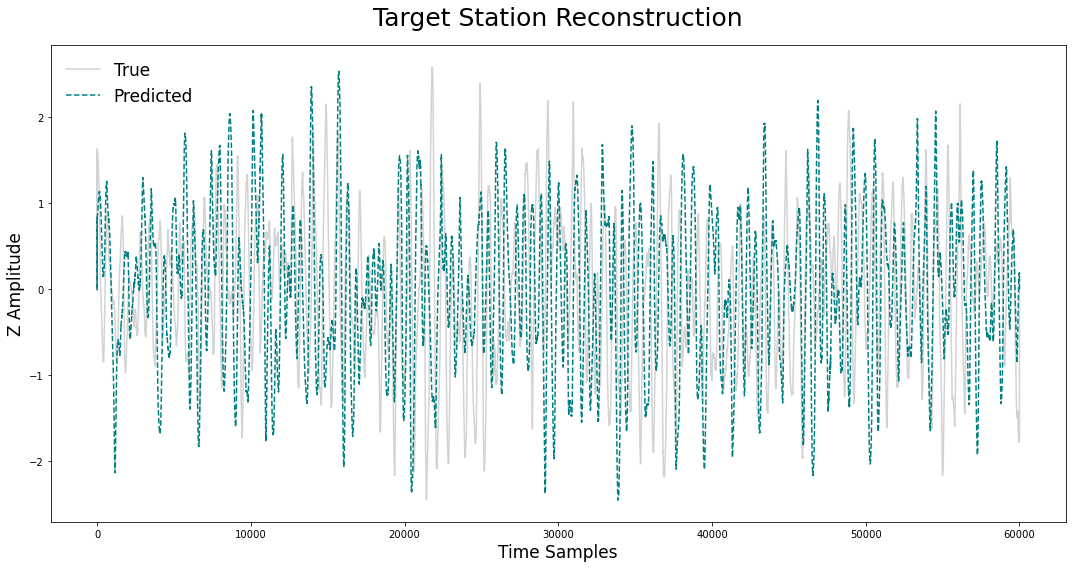

In [202]:
figONE, ax = plt.subplots(figsize=(15,8))

ax.plot(Y_true_full, label="True", color = "lightgray")
ax.plot(Y_pred_full, label="Predicted", linestyle="--", color = "teal")

ax.set_xlabel('Time Samples', fontsize=17)
ax.set_ylabel('Z Amplitude', fontsize=17)
ax.set_title('Target Station Reconstruction',
             fontsize=25, pad=20)

ax.legend(fontsize=17, frameon= False, loc='upper left')
plt.tight_layout()
plt.show()

In [203]:
filepath = "/Users/elliotlowe/Report/Chapter4_"
filename = "/TS_Results1"

figONE.savefig(filepath+filename, dpi=300, bbox_inches='tight')

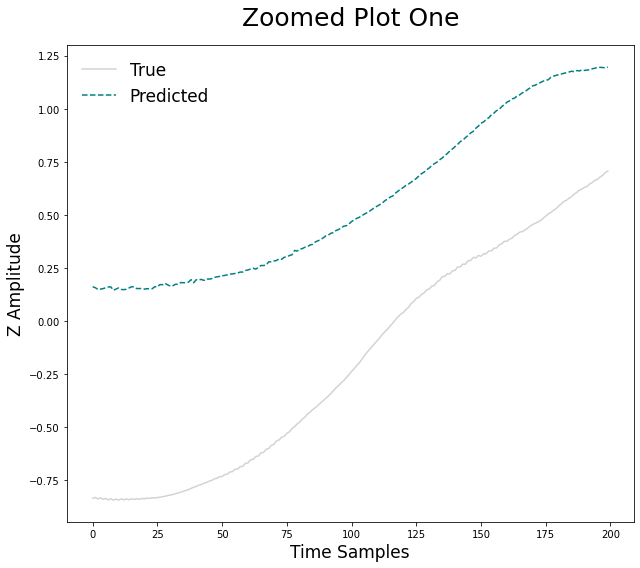

In [147]:
figONE_zoomed1, ax = plt.subplots(figsize=(9,8))

start = 400
end = start+ 200

ax.plot(Y_true_full[start:end], label="True", color = "lightgray")
ax.plot(Y_pred_full[start:end], label="Predicted", linestyle="--", color = "teal")

ax.set_xlabel('Time Samples', fontsize=17)
ax.set_ylabel('Z Amplitude', fontsize=17)
ax.set_title('Zoomed Plot One',
             fontsize=25, pad=20)

ax.legend(fontsize=17, frameon= False, loc='upper left')
plt.tight_layout()
plt.show()

In [150]:
filepath = "/Users/elliotlowe/Report/Chapter4_"
filename = "/TS_Results2"

figONE_zoomed1.savefig(filepath+filename, dpi=300, bbox_inches='tight')

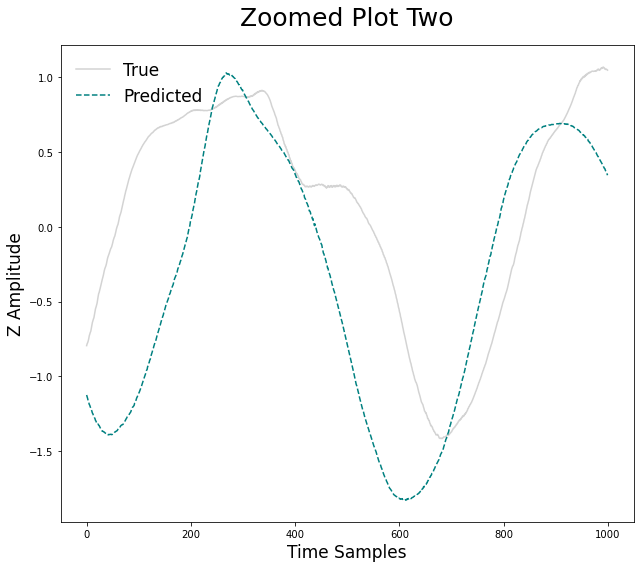

In [204]:
figONE_zoomed2, ax = plt.subplots(figsize=(9,8))

start = 6000
end   = start + 1000

ax.plot(Y_true_full[start:end], label="True", color = "lightgray")
ax.plot(Y_pred_full[start:end], label="Predicted", linestyle="--", color = "teal")

ax.set_xlabel('Time Samples', fontsize=17)
ax.set_ylabel('Z Amplitude', fontsize=17)
ax.set_title('Zoomed Plot Two',
             fontsize=25, pad=20)

ax.legend(fontsize=17, frameon= False, loc='upper left')
plt.tight_layout()
plt.show()

In [205]:
filepath = "/Users/elliotlowe/Report/Chapter4_"
filename = "/TS_Results3"

figONE_zoomed2.savefig(filepath+filename, dpi=300, bbox_inches='tight')

In [189]:
True_Data = Windowed_data[100+test_i]
True_Data = True_Data[:,start:end]
Recreated_data = True_Data.copy()
Recreated_data[target_idx] = Y_pred_full[start:end]